# Testing the ability to distinguish signal events from background

In [46]:
%pylab inline
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [47]:
from hits import AllHits
hits = AllHits('../data/signal_TDR.root')

### Record (Raw) Wire Features 

In [48]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
deposits *= 100 # to avoid small numbers for GBRT
# Time after triggering that signal waveforms starts
rel_time = numpy.vstack(hits.get_relative_time(i) for i in range(hits.n_events))
# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Signal like or not (apriori)
sig_like = numpy.vstack(hits.get_prob_sig_wire(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.cydet.point_rhos for i in range(hits.n_events))

In [49]:
labels.shape, deposits.shape

((3445, 4482), (3445, 4482))

## Preapre Neighbour Features

In [50]:
# Sum of energy desposits of neighbours 
sum_neigh_deposits = hits.cydet.point_neighbours.dot(deposits.T).T
# Sum of neighbouring neighbour deposits (smoothed clustering)
sum_neigh_deposits_2 = hits.cydet.point_neighbours.dot(sum_neigh_deposits.T).T
sum_neigh_deposits_2 -= deposits # wires pick up their own value, subtract it back out
# Number of neighbours with hits
num_neigh_deposits = hits.cydet.point_neighbours.dot(deposits.T > 0).T
# Number of signal-like neighbours
sig_like_neighs = hits.cydet.point_neighbours.dot(sig_like.T).T

### Left/Right Neighbour Features

In [51]:
# Sum of energy desposits of left/right neighbours 
sum_lr_deposits = hits.cydet.lr_neighbours.dot(deposits.T).T
# Sum of left/right neighbouring left/right neighbour deposits
sum_lr_deposits_2 = hits.cydet.lr_neighbours.dot(sum_neigh_deposits.T).T
sum_lr_deposits_2 -= deposits # wires pick up their own value, subtract it back out
# Number of neighbours with hits
num_lr_deposits = hits.cydet.lr_neighbours.dot(deposits.T > 0).T
# Number of signal-like neighbours
sig_like_lr = hits.cydet.lr_neighbours.dot(sig_like.T).T
# Sum of relative timing of left/right neighbours
sum_lr_time = hits.cydet.lr_neighbours.dot(rel_time.T).T
# Get difference measure of time between hit and possible neighbouring hits
diff_lr_time_metric = numpy.vstack(hits.get_time_neighbours_metric(i) for i in range(hits.n_events))

In [52]:
#diff_lr_time_metric = numpy.log(diff_lr_time_metric)

## Train/test splitting 

In [53]:
from sklearn.cross_validation import train_test_split
train_events, test_events = train_test_split(range(len(labels)), train_size=0.15, test_size=0.25)

In [54]:
from collections import OrderedDict
features = OrderedDict()
# Wire features
features['deposit'] = deposits * 100
features['rel_time'] = rel_time
features['layer_id'] = layer_id
# Neighbour Features
features['sum_neigh_deposits'] = sum_neigh_deposits * 100
features['num_neigh_deposits'] = num_neigh_deposits
features['sum_neigh_deposits_2'] = sum_neigh_deposits_2
features['sig_like_neighs'] = sig_like_neighs
# Left-Right neighbour features
features['sum_lr_deposits'] = sum_lr_deposits * 100
features['sum_lr_time'] = sum_lr_time
features['num_lr_deposits'] = num_lr_deposits
features['sum_lr_deposits_2'] = sum_lr_deposits_2
features['sig_like_lr'] = sig_like_lr
features['diff_lr_time_metric'] = diff_lr_time_metric
# Truth values
features['labels'] = labels

In [55]:
train_features = features.keys()[:-1]

In [56]:
data = numpy.dstack(features.values())

In [57]:
data.shape

(3445, 4482, 14)

In [58]:
n_feats = data.shape[-1]
train_data, test_data = data[train_events].reshape(-1, n_feats), data[test_events].reshape(-1, n_feats)

In [59]:
import pandas
train_data = pandas.DataFrame(data=train_data, columns=features.keys())
test_data = pandas.DataFrame(data=test_data, columns=features.keys())

### Purge out cells with no hits, relabel 1 as signal hit, 0 as background hit

In [60]:
train_data = train_data[train_data['labels'] != 0]
test_data = test_data[test_data['labels'] != 0]

train_data['labels'] = 2 - train_data['labels']
test_data['labels'] = 2 - test_data['labels']

## Using simple GBRT to determine if wire is signal

In [61]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [62]:
factory = ClassifiersFactory()
gb_all_features = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
gb_deposit = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=['deposit'])
factory.add_classifier('All Features', gb_all_features)
factory.add_classifier('Energy Deposit', gb_deposit)

In [63]:
factory.fit(train_data, train_data['labels'])
pass

model All Features was trained in 89.77 seconds
model Energy Deposit was trained in 14.20 seconds
Totally spent 103.97 seconds on training


In [64]:
predictions = factory.test_on(test_data, test_data['labels'])

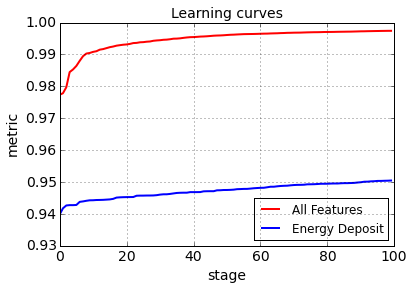

In [65]:
from rep.report.metrics import RocAuc
predictions.learning_curve(RocAuc(), steps=1)

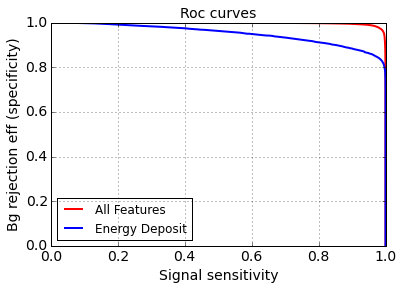

In [66]:
roc = predictions.roc()
roc.plot()

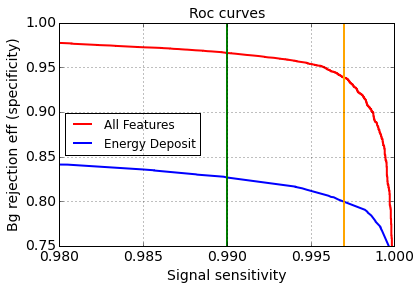

In [67]:
roc.plot(xlim=[0.98,1.], ylim=[0.75,1.])
plt.plot([.99, .99], [0.75, 1.], 'k-', lw=2,  c='g' )
plt.plot([.997, .997], [0.75, 1.], 'k-', lw=2,c='orange')


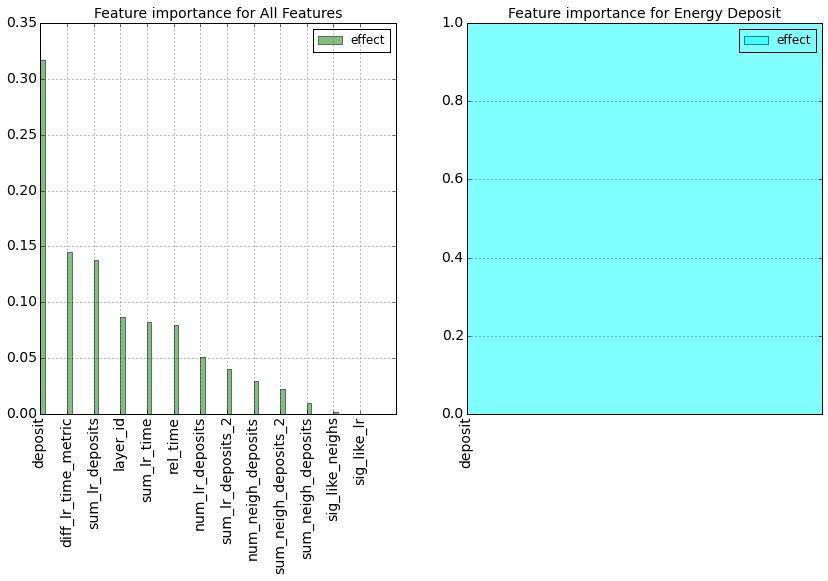

In [68]:
predictions.feature_importance().plot(figsize=[14, 7])

In [69]:
corr = predictions.features_correlation_matrix(features=train_features)
corr.cmap = "PuOr"

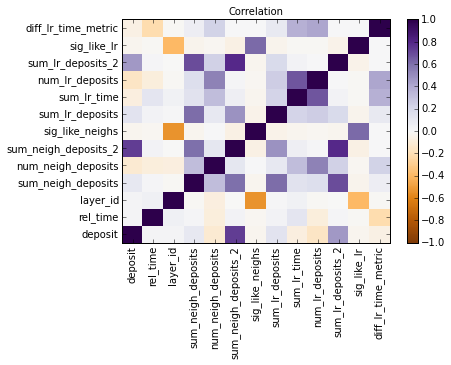

In [70]:
corr.plot()

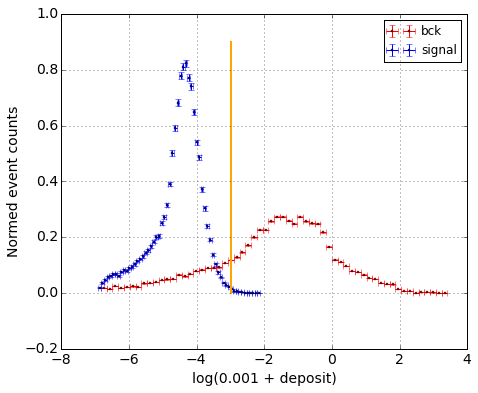

In [71]:
dep = predictions.features_pdf(features=['log(0.001 + deposit)'], bins=60)
dep.plot()
plt.plot([log(0.001+0.05), log(0.001+0.05)], [0, 0.9], 'k-', lw=2,c='orange')

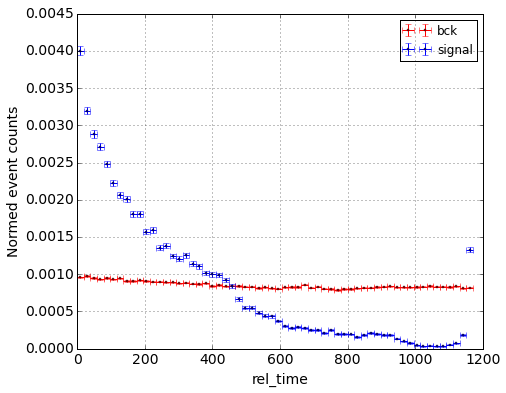

In [72]:
predictions.features_pdf(features=['rel_time'], bins=60)

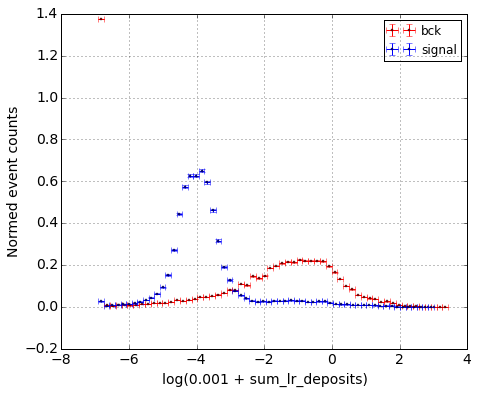

In [73]:
predictions.features_pdf(features=['log(0.001 + sum_lr_deposits)'], bins=60)

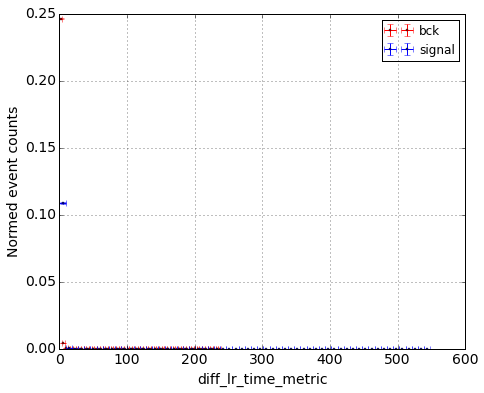

In [74]:
predictions.features_pdf(features=['diff_lr_time_metric'], bins=60)

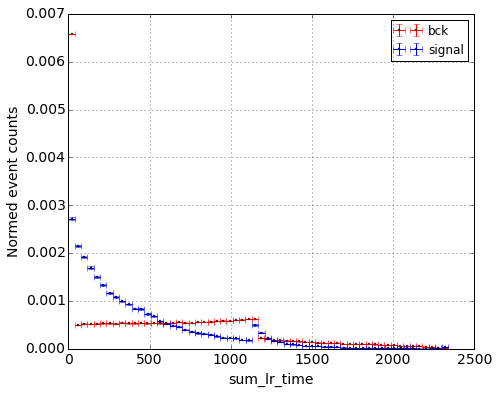

In [75]:
predictions.features_pdf(features=['sum_lr_time'], bins=60)

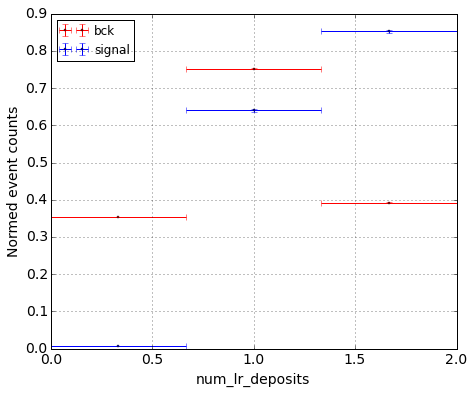

In [76]:
predictions.features_pdf(features=['num_lr_deposits'], bins=3)

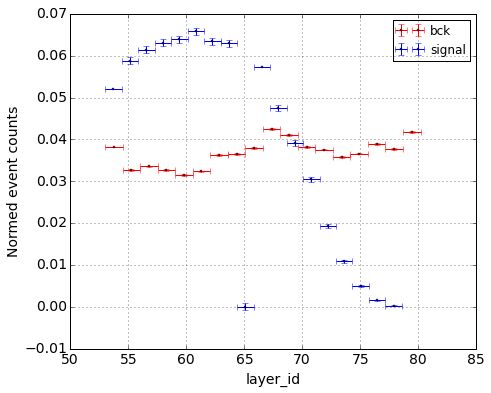

In [77]:
predictions.features_pdf(features=['layer_id'], bins=18)

### Original Background Regection/Singal Retention at 5 KeV

In [78]:
n_sig = 0 
n_sig_pass = 0
n_bkg = 0 
n_bkg_pass = 0
for evt in range(hits.n_events):
        sig_wires = hits.get_sig_wires(evt)
        sig_wires_pass = where(hits.get_energy_deposits(evt)[sig_wires] < 0.000005)[0]
        n_sig += len(sig_wires)
        n_sig_pass += len(sig_wires_pass)
        
        bkg_wires = hits.get_bkg_wires(evt)
        bkg_wires_pass = where(hits.get_energy_deposits(evt)[bkg_wires] < 0.000005)[0]
        n_bkg += len(bkg_wires)
        n_bkg_pass += len(bkg_wires_pass)
print "Signal Retention Rate {}".format(n_sig_pass/float(n_sig))
print "Background Rejection Rate {}".format(n_bkg_pass/float(n_bkg))

# Save these values for comparison later
tpr_orig = n_sig_pass/float(n_sig)
fpr_orig = n_bkg_pass/float(n_bkg)

Signal Retention Rate 0.99706385438
Background Rejection Rate 0.20393287988


In [79]:
from sklearn.metrics import roc_curve
new_tpr = 0.99
new_fpr = 0.10
tpr_orig_index =  where(tpr > tpr_orig)[0][1]
fpr_orig_index =  where(fpr > fpr_orig)[0][1]

tpr_new_index =  where(tpr > new_tpr)[0][1]
fpr_new_index =  where(fpr > new_fpr)[0][1]

print "At signal retetion rate at 5 KeV cut, {0:.5f} , background regjection has changed from".format(tpr_orig) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(1-fpr_orig,1-fpr[tpr_orig_index],fpr_orig-fpr[tpr_orig_index]) + \
      " or factor {0:.2f}\n".format((fpr_orig)/(fpr[tpr_orig_index]))
print "At background retetion rate at 5 KeV cut, {0:.5f} , signal retention has changed from".format(1-fpr_orig) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(tpr_orig,tpr[fpr_orig_index], tpr[fpr_orig_index]-tpr_orig) + \
      " or factor {0:.2f}\n".format((1-tpr_orig)/(1-tpr[fpr_orig_index]))

print "At new signal retention of {0:.5f}, background regjection has changed from".format(new_tpr) + \
      "\n{0:.5f} to {1:.5f} improving by {2:.5f}".format(1-fpr_orig,1-fpr[tpr_new_index], fpr_orig-fpr[tpr_new_index])+ \
      " or factor {0:.2f}\n".format((fpr_orig)/(fpr[tpr_new_index]))
print "At new background rejection rate of {0:.5f}, signal retention has changed from".format(new_fpr) + \
      "\n{0:.5} to {1:.5f} improving by {2:.5f}".format(tpr_orig,tpr[fpr_new_index], tpr[fpr_new_index]-tpr_orig) + \
      " or factor {0:.2f}\n".format((1-tpr_orig)/(1-tpr[fpr_new_index]))


At signal retetion rate at 5 KeV cut, 0.99706 , background regjection has changed from
0.79607 to 0.94267 improving by 0.14660 or factor 3.56

At background retetion rate at 5 KeV cut, 0.79607 , signal retention has changed from
0.99706 to 0.99977 improving by 0.00271 or factor 12.79

At new signal retention of 0.99000, background regjection has changed from
0.79607 to 0.96769 improving by 0.17163 or factor 6.31

At new background rejection rate of 0.10000, signal retention has changed from
0.99706 to 0.99897 improving by 0.00191 or factor 2.86



#Full Algorithm with Hough Transform

In [80]:
from tracking import Hough
from sklearn.preprocessing import normalize
hough = Hough(hits)

In [81]:
def setup_plot_for_detector(size=(15, 15)):
    figsize(*size)
    axes(polar=True)
    # set appropriate
    ylim(0, 85)   
rhos, phis = hits.cydet.get_points_rhos_and_phis()
xs, ys = hits.cydet.get_points_xs_and_ys()
t_rhos, t_phis = hough.track.get_points_rhos_and_phis()
t_xs, t_ys = hough.track.get_points_xs_and_ys()

### Get the events that were not used in training

In [82]:
vis_events = numpy.setdiff1d(range(hits.n_events), train_events)
vis_data = data[vis_events].reshape(-1, n_feats)
vis_data = pandas.DataFrame(data=vis_data, columns=features.keys())

### Visualize the fit

In [83]:
# Get the right indecies of the wires for the flattened data
vis_evt = 4
wire_min = vis_evt*hits.cydet.n_points
wire_max = wire_min + hits.cydet.n_points

# Get the index corresponding to the full set of events
evt = vis_events[vis_evt]

sig = hits.get_sig_wires(evt)
bkg = hits.get_bkg_wires(evt)
hit_vector = hits.get_hit_vector(evt)

In [84]:
gbdt = factory['All Features']
gbdt_out = gbdt.predict_proba(vis_data[wire_min:wire_max])[:,1]
hit_vector = hit_vector*gbdt_out

hough_matrix = hough.correspondence.T
hough_matrix = normalize(hough_matrix, norm='l2', axis=1)

inv_hough_matrix = hough.correspondence
#inv_hough_matrix = normalize(inv_hough_matrix, norm='l2', axis=1)

track_center = hough_matrix.dot(hit_vector) 
center = np.where(track_center == max(track_center))[0]

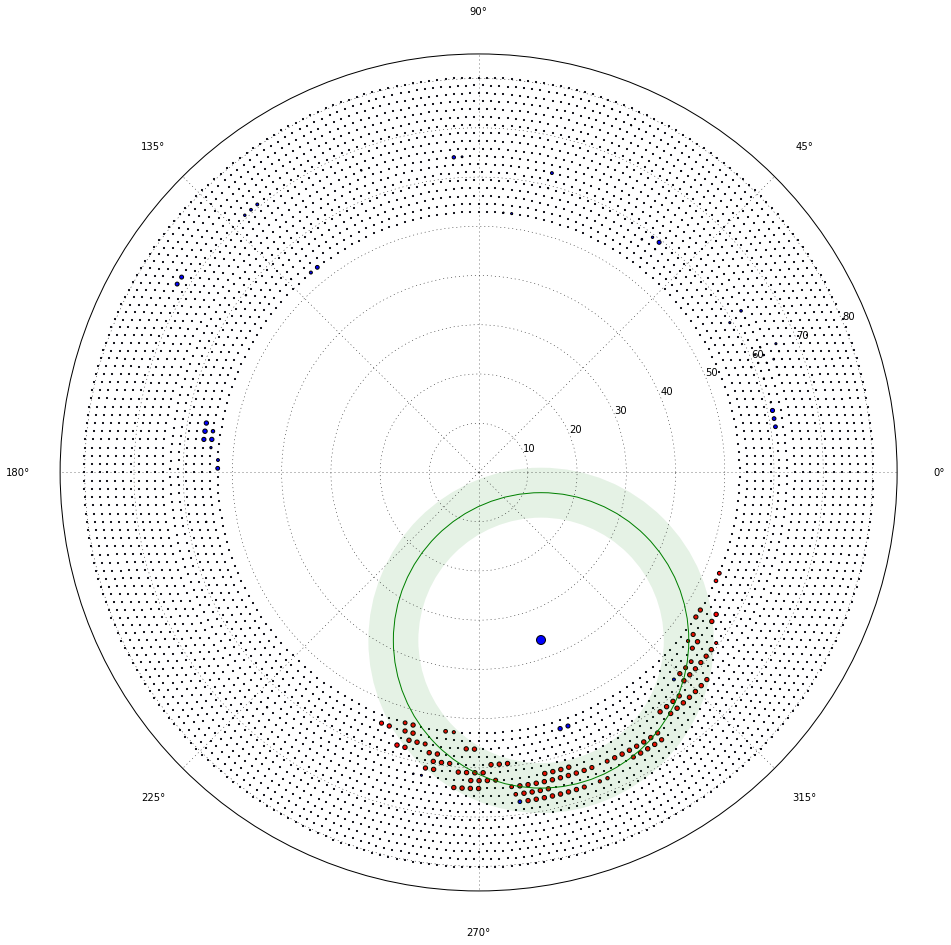

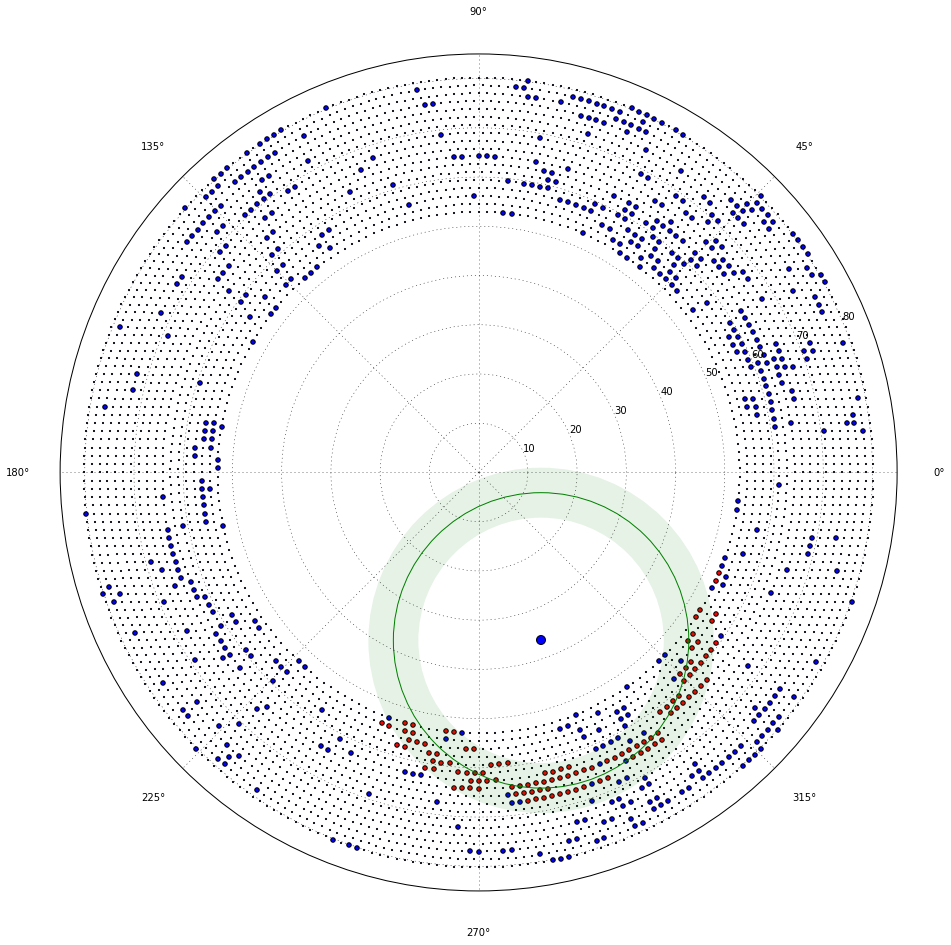

In [85]:
## Output with hough transform
setup_plot_for_detector()
ax = plt.subplot(111, polar=True)
ax.scatter(phis, rhos, marker='.', s=5)
ax.scatter(t_phis[center],t_rhos[center],s=80, marker='o', c='b') 
ax.scatter(phis[sig],rhos[sig], hit_vector[sig]*20, marker='o', c='r')
ax.scatter(phis[bkg],rhos[bkg], hit_vector[bkg]*20, marker='o', c='b')

target_radius = plt.Circle((t_xs[center], t_ys[center]), hough.sig_rho, \
                           transform=ax.transData._b, color="green", fill=False,)
target_spread = plt.Circle((t_xs[center], t_ys[center]), hough.sig_rho, \
                           transform=ax.transData._b, color="green", alpha=0.1, fill=False, lw=10*hough.sig_trk_smear)
gca().add_artist(target_radius)
gca().add_artist(target_spread)
show()

## Output showing original background/signal
setup_plot_for_detector()
ax = plt.subplot(111, polar=True)
ax.scatter(phis, rhos, marker='.', s=5)
ax.scatter(t_phis[center],t_rhos[center],s=80, marker='o', c='b') 
ax.scatter(phis[sig],rhos[sig], marker='o', c='r')
ax.scatter(phis[bkg],rhos[bkg], marker='o', c='b')


target_radius = plt.Circle((t_xs[center], t_ys[center]), hough.sig_rho, \
                           transform=ax.transData._b, color="green", fill=False,)
target_spread = plt.Circle((t_xs[center], t_ys[center]), hough.sig_rho, \
                           transform=ax.transData._b, color="green", alpha=0.1, fill=False, lw=10*hough.sig_trk_smear)
gca().add_artist(target_radius)
gca().add_artist(target_spread)
show()

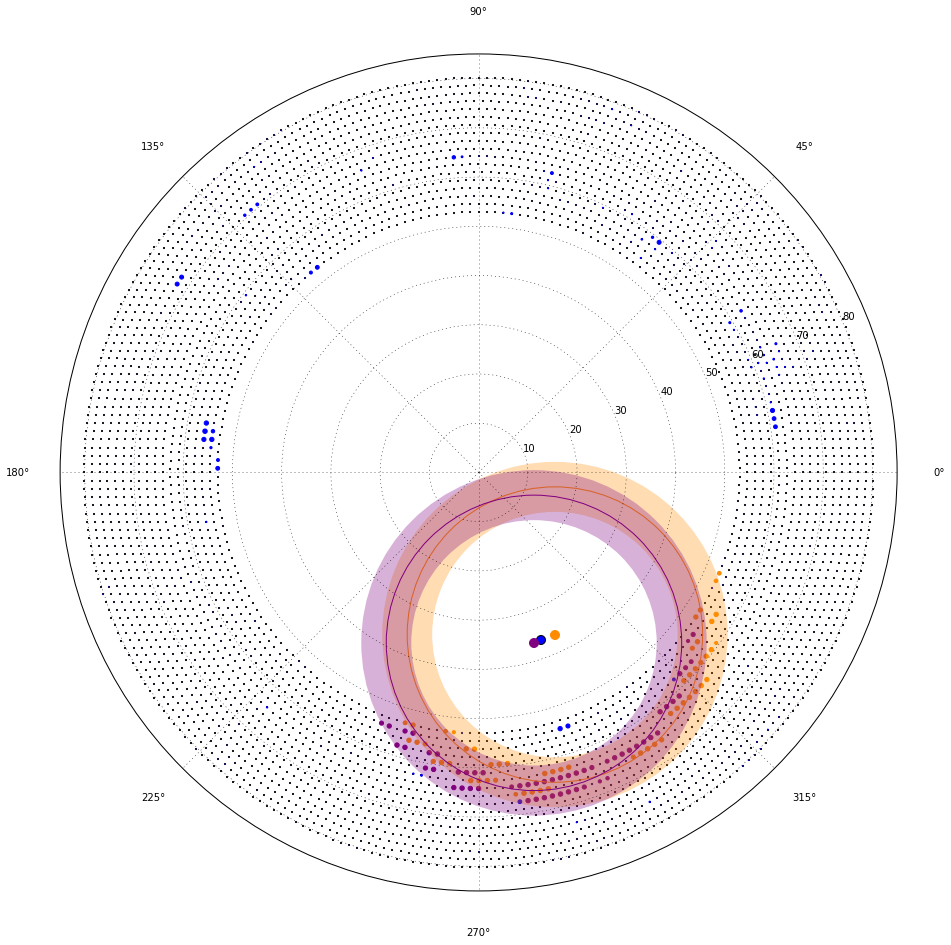

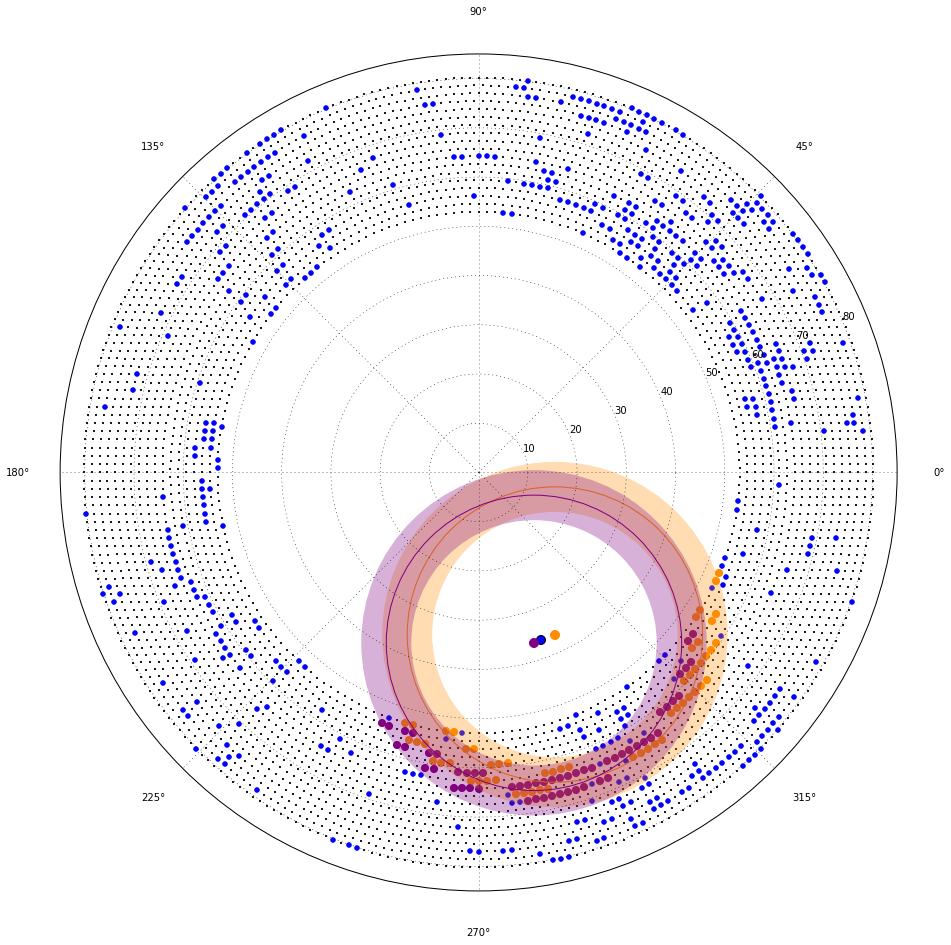

In [86]:
even_sig, odd_sig = hits.get_hit_wires_even_odd(evt)
even_sig = np.intersect1d(even_sig, sig)
odd_sig = np.intersect1d(odd_sig, sig)

even_hit_vector, odd_hit_vector = hits.get_hit_vector_even_odd(evt)
even_hit_vector = even_hit_vector*gbdt_out
odd_hit_vector = odd_hit_vector*gbdt_out


## Start with Even Layer
track_center_even = hough_matrix.dot(even_hit_vector)
center_even = np.where(track_center_even == max(track_center_even))[0]

## Do odd layer
track_center_odd = hough_matrix.dot(odd_hit_vector)
center_odd = np.where(track_center_odd == max(track_center_odd))[0]

# PLOT with hit scaling
setup_plot_for_detector()
ax = plt.subplot(111, polar=True)
ax.scatter(phis, rhos, marker='.', s=5)
ax.scatter(t_phis[center],t_rhos[center],s=80, marker='o', c='b') 
ax.scatter(phis[bkg],rhos[bkg], hit_vector[bkg]*20, marker='o', color='blue')

#Even layer
ax.scatter(t_phis[center_even],t_rhos[center_even],s=80, marker='o', color='darkorange') 
ax.scatter(phis[even_sig],rhos[even_sig],  hit_vector[even_sig]*20, marker='o', color='darkorange')
target_radius_even = plt.Circle((t_xs[center_even], t_ys[center_even]), hough.sig_rho, \
                           transform=ax.transData._b, color='darkorange', fill=False,)
target_spread_even = plt.Circle((t_xs[center_even], t_ys[center_even]), hough.sig_rho, \
                           transform=ax.transData._b, color='darkorange', alpha=0.3, fill=False, lw=10*hough.sig_trk_smear)
gca().add_artist(target_radius_even)
gca().add_artist(target_spread_even)


#Odd layer
ax.scatter(t_phis[center_odd],t_rhos[center_odd],s=80, marker='o', color='purple') 
ax.scatter(phis[odd_sig],rhos[odd_sig], hit_vector[odd_sig]*20, marker='o', color='purple')

target_radius_odd = plt.Circle((t_xs[center_odd], t_ys[center_odd]), hough.sig_rho, \
                           transform=ax.transData._b, color="purple", fill=False,)
target_spread_odd = plt.Circle((t_xs[center_odd], t_ys[center_odd]), hough.sig_rho, \
                           transform=ax.transData._b, color="purple", alpha=0.3, fill=False, lw=10*hough.sig_trk_smear)
gca().add_artist(target_radius_odd)
gca().add_artist(target_spread_odd)
show()

# PLOT without hit scaling
setup_plot_for_detector()
ax = plt.subplot(111, polar=True)
ax.scatter(phis, rhos, marker='.', s=5)
ax.scatter(t_phis[center],t_rhos[center],s=80, marker='o', c='b') 
ax.scatter(phis[bkg],rhos[bkg], marker='o', color='blue')

#Even layer
ax.scatter(t_phis[center_even],t_rhos[center_even],s=80, marker='o', color='darkorange') 
ax.scatter(phis[even_sig],rhos[even_sig],  marker='o', s=50, color='darkorange')
target_radius_even = plt.Circle((t_xs[center_even], t_ys[center_even]), hough.sig_rho, \
                           transform=ax.transData._b, color='darkorange', fill=False,)
target_spread_even = plt.Circle((t_xs[center_even], t_ys[center_even]), hough.sig_rho, \
                           transform=ax.transData._b, color='darkorange', alpha=0.3, fill=False, lw=10*hough.sig_trk_smear)
gca().add_artist(target_radius_even)
gca().add_artist(target_spread_even)


#Odd layer
ax.scatter(t_phis[center_odd],t_rhos[center_odd],s=80, marker='o', color='purple') 
ax.scatter(phis[odd_sig],rhos[odd_sig], s=50, marker='o', color='purple')

target_radius_odd = plt.Circle((t_xs[center_odd], t_ys[center_odd]), hough.sig_rho, \
                           transform=ax.transData._b, color="purple", fill=False,)
target_spread_odd = plt.Circle((t_xs[center_odd], t_ys[center_odd]), hough.sig_rho, \
                           transform=ax.transData._b, color="purple", alpha=0.3, fill=False, lw=10*hough.sig_trk_smear)
gca().add_artist(target_radius_odd)
gca().add_artist(target_spread_odd)
show()